In [8]:
import torch
import glob
import numpy as np
import pandas as pd
import yaml
import math
import scipy.io as sio
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from pathlib import Path
import unittest
from scipy.special import legendre

from plotting import *
from utils import *
from TMP_model import MP_model,TestTMPModel



In [ ]:


# Step 1: Generate sample time series data (or load your own)
np.random.seed(42)  # For reproducibility
n_points = 100
time = np.linspace(0, 10, n_points)
# Creating a complex signal with noise
true_signal = 2 * np.sin(time) + 0.5 * np.cos(3 * time) + 0.3 * time
noise = np.random.normal(0, 0.5, n_points)
data = true_signal + noise

# Step 2: Normalize time to [-1, 1] range
time_normalized = 2 * (time - np.min(time)) / (np.max(time) - np.min(time)) - 1

# Step 3: Define the order of Legendre polynomial expansion
order = 10  # You can adjust this based on your data complexity

# Step 4: Construct the design matrix
X = np.zeros((n_points, order + 1))
for i in range(order + 1):
    # Generate the ith Legendre polynomial
    P_i = legendre(i)
    X[:, i] = P_i(time_normalized)

# Step 5: Fit the coefficients using least squares
coefficients, residuals, rank, s = np.linalg.lstsq(X, data, rcond=None)

# Step 6: Compute the fitted values
fitted_values = X @ coefficients

# Step 7: Plot the results
plt.figure(figsize=(12, 6))
plt.plot(time, data, 'o', alpha=0.5, label='Original Data')
plt.plot(time, fitted_values, 'r-', label=f'Legendre Fit (order {order})')
plt.plot(time, true_signal, 'g--', label='True Signal (without noise)')
plt.legend()
plt.title('Time Series Fitting with Legendre Polynomials')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 8: Evaluate the quality of the fit
mse = np.mean((fitted_values - data) ** 2)
rmse = np.sqrt(mse)
print(f"Root Mean Square Error: {rmse:.4f}")

# Calculate Variance Accounted For (VAF)
# VAF is similar to R-squared and measures the proportion of variance explained by the model
total_variance = np.var(data)
residual_variance = np.var(data - fitted_values)
vaf = 100 * (1 - residual_variance / total_variance)
print(f"Variance Accounted For (VAF): {vaf:.2f}%")

# Alternative calculation using the formula: 1 - SSE/SST
sse = np.sum((data - fitted_values) ** 2)  # Sum of squared errors
sst = np.sum((data - np.mean(data)) ** 2)  # Total sum of squares
vaf_alt = 100 * (1 - sse / sst)
print(f"VAF (alternative calculation): {vaf_alt:.2f}%")

# Step 9: Predict for new values (if needed)
def predict(new_time, coefficients, original_time_min, original_time_max):
    """Make predictions at new time points using the fitted Legendre model"""
    # Normalize the new time points
    new_time_normalized = 2 * (new_time - original_time_min) / (original_time_max - original_time_min) - 1
    
    # Create the design matrix for the new points
    X_new = np.zeros((len(new_time), len(coefficients)))
    for i in range(len(coefficients)):
        P_i = legendre(i)
        X_new[:, i] = P_i(new_time_normalized)
    
    # Calculate predictions
    predictions = X_new @ coefficients
    return predictions

# Example of making predictions
future_time = np.linspace(10, 12, 20)  # Predict beyond the original time range
predictions = predict(future_time, coefficients, np.min(time), np.max(time))

# plt.figure(figsize=(12, 6))
# plt.plot(time, data, 'o', alpha=0.5, label='Original Data')
# plt.plot(time, fitted_values, 'r-', label='Legendre Fit')
# plt.plot(future_time, predictions, 'b-', label='Predictions')
# plt.axvline(x=10, color='k', linestyle='--', alpha=0.3)  # Mark the boundary between data and predictions
# plt.legend()
# plt.title('Time Series Prediction with Legendre Polynomials')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# Step 10: Analyze the coefficients
plt.figure(figsize=(10, 5))
plt.bar(range(len(coefficients)), np.abs(coefficients))
plt.xlabel('Polynomial Order')
plt.ylabel('Coefficient Magnitude')
plt.title('Magnitude of Legendre Polynomial Coefficients')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import legendre

def fit_legendre(time, data, order, plot=True, title="Time Series Fitting with Legendre Polynomials"):
    """
    Fit Legendre polynomials to time series data.
    
    Parameters:
    -----------
    time : array-like
        The time points of the data.
    data : array-like
        The observed values at each time point.
    order : int
        The order of Legendre polynomial expansion (number of terms - 1).
    plot : bool, optional (default=True)
        Whether to generate and display the fitting plot.
    title : str, optional
        The title for the plot.
        
    Returns:
    --------
    dict
        A dictionary containing:
        - 'coefficients': The fitted Legendre polynomial coefficients
        - 'fitted_values': The fitted values at each time point
        - 'vaf': Variance Accounted For (percentage)
        - 'rmse': Root Mean Square Error
        - 'residuals': The residuals (data - fitted_values)
        - 'normalized_time': The normalized time values used for fitting
        - 'design_matrix': The design matrix of Legendre polynomials
    """
    # Convert inputs to numpy arrays if they aren't already
    time = np.array(time)
    data = np.array(data)
    
    # Step 1: Normalize time to [-1, 1] range
    time_min, time_max = np.min(time), np.max(time)
    time_normalized = 2 * (time - time_min) / (time_max - time_min) - 1
    
    # Step 2: Construct the design matrix
    X = np.zeros((len(time), order + 1))
    for i in range(order + 1):
        # Generate the ith Legendre polynomial
        P_i = legendre(i)
        X[:, i] = P_i(time_normalized)
    
    # Step 3: Fit the coefficients using least squares
    coefficients, residuals, rank, s = np.linalg.lstsq(X, data, rcond=None)
    
    # Step 4: Compute the fitted values
    fitted_values = X @ coefficients
    
    # Step 5: Calculate error metrics
    residuals = data - fitted_values
    mse = np.mean(residuals ** 2)
    rmse = np.sqrt(mse)
    
    # Calculate Variance Accounted For (VAF)
    total_variance = np.var(data)
    residual_variance = np.var(residuals)
    vaf = 100 * (1 - residual_variance / total_variance)
    
    # Calculate Sum of Squared Error
    sse = np.sum(residuals ** 2)
    
    # Step 6: Plot the results if requested
    if plot:
        plt.figure(figsize=(12, 8))
        
        # Plot original data and fitted values
        plt.plot(time, data, 'o', alpha=0.5, label='Original Data')
        plt.plot(time, fitted_values, 'r-', linewidth=2, label=f'Legendre Fit (order {order})')
        
        # Add labels and title
        plt.legend(fontsize=12)
        plt.title(title, fontsize=14)
        plt.xlabel('Time', fontsize=12)
        plt.ylabel('Value', fontsize=12)
        plt.grid(True, alpha=0.3)
        
        # Add text box with metrics
        metrics_text = f"VAF: {vaf:.2f}%\nRMSE: {rmse:.4f}\nSSE: {sse:.4f}"
        plt.figtext(0.15, 0.15, metrics_text, fontsize=12, 
                   bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
        
        plt.tight_layout()
        plt.show()
        
        # Also plot the coefficient magnitudes
        plt.figure(figsize=(10, 5))
        plt.bar(range(len(coefficients)), np.abs(coefficients))
        plt.xlabel('Polynomial Order', fontsize=12)
        plt.ylabel('Coefficient Magnitude', fontsize=12)
        plt.title('Magnitude of Legendre Polynomial Coefficients', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # Return results in a dictionary
    results = {
        'coefficients': coefficients,
        'fitted_values': fitted_values,
        'vaf': vaf,
        'rmse': rmse,
        'sse': sse,
        'residuals': residuals,
        'normalized_time': time_normalized,
        'design_matrix': X
    }
    
    return results



In [7]:

# Example usage
if __name__ == "__main__":
    # Generate sample time series data
    np.random.seed(42)  # For reproducibility
    n_points = 100
    time = np.linspace(0, 10, n_points)
    
    # Creating a complex signal with noise
    true_signal = 2 * np.sin(time) + 0.5 * np.cos(3 * time) + 0.3 * time
    noise = np.random.normal(0, 0.5, n_points)
    data = true_signal + noise
    
    # Fit with different orders and compare
    results_order_10 = fit_legendre(time, data, order=10,plot=False, title="Legendre Fit with Order 10")
   
    # Print comparison of VAF for different orders
    print(f"Order 10 - VAF: {results_order_10['vaf']:.2f}%, RMSE: {results_order_10['rmse']:.4f}")
   

Order 10 - VAF: 90.37%, RMSE: 0.5077


In [ ]:
destination_folder = "../../../data/MMpose/segmented_files/walking/bvh_files"
folder_path = "../../../../movement_repo/data/MMpose/bvh_files" 
folder_path = destination_folder  
bvh_data = read_bvh_files(folder_path)

processed_data = process_bvh_data(bvh_data)
num_segments = len(processed_data)
# based on TMP code: the format of data=list(segment_data[signals,time]) --> signals are fixed but time 
# could vary in segments
# as far as i underastand:
# num segments = number of videos segment we have (all segments*each subject)
# num_signals =  number of sensors/signals. = number of features / joint info in data = 54 here
print(f'num of segments : {num_segments}')
num_signals = processed_data[0].shape[0]
print(f'num of signal : {num_signals}')

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import legendre
import os
import re
from matplotlib.gridspec import GridSpec

def fit_legendre_to_signal(time_points, signal_data, order):
    """
    Fit Legendre polynomials to a single signal.
    
    Parameters:
    -----------
    time_points : array-like
        The time points of the signal.
    signal_data : array-like
        The signal values at each time point.
    order : int
        The order of Legendre polynomial expansion.
        
    Returns:
    --------
    dict
        Dictionary with fitting results.
    """
    # Normalize time to [-1, 1] range
    time_min, time_max = np.min(time_points), np.max(time_points)
    time_normalized = 2 * (time_points - time_min) / (time_max - time_min) - 1
    
    # Construct the design matrix
    X = np.zeros((len(time_points), order + 1))
    for i in range(order + 1):
        P_i = legendre(i)
        X[:, i] = P_i(time_normalized)
    
    # Fit using least squares
    coefficients, residuals, rank, s = np.linalg.lstsq(X, signal_data, rcond=None)
    
    # Calculate fitted values
    fitted_values = X @ coefficients
    
    # Calculate metrics
    residuals = signal_data - fitted_values
    mse = np.mean(residuals ** 2)
    rmse = np.sqrt(mse)
    
    # Calculate VAF
    total_variance = np.var(signal_data)
    residual_variance = np.var(residuals)
    # Handle cases where total_variance is too small
    if total_variance < 1e-10:
        vaf = 100.0 if residual_variance < 1e-10 else 0.0
    else:
        vaf = 100 * (1 - residual_variance / total_variance)
    
    return {
        'coefficients': coefficients,
        'fitted_values': fitted_values,
        'vaf': vaf,
        'rmse': rmse,
        'residuals': residuals,
        'normalized_time': time_normalized
    }

def analyze_mocap_segments(processed_data, poly_order, signal_names=None, plot_summary=True, plot_details=False, max_signals_to_plot=10):
    """
    Analyze motion capture data segments using Legendre polynomials.
    
    Parameters:
    -----------
    processed_data : list
        List of numpy arrays, where each array has shape [num_signals, time_points]
    poly_order : int
        The order of Legendre polynomial expansion.
    signal_names : list, optional
        Names of the signals/joints.
    plot_summary : bool, optional
        Whether to plot the summary of VAF across segments.
    plot_details : bool, optional
        Whether to plot detailed fitting for selected signals.
    max_signals_to_plot : int, optional
        Maximum number of signals to plot in detail.
        
    Returns:
    --------
    dict
        A dictionary containing VAF results for all segments and signals.
    """
    num_segments = len(processed_data)
    if num_segments == 0:
        raise ValueError("No data segments provided")
    
    num_signals = processed_data[0].shape[0]
    
    # If signal names are not provided, create generic names
    if signal_names is None:
        signal_names = [f"Signal_{i+1}" for i in range(num_signals)]
    elif len(signal_names) != num_signals:
        print(f"Warning: {len(signal_names)} signal names provided, but data has {num_signals} signals")
        # Extend or truncate signal_names as needed
        if len(signal_names) < num_signals:
            signal_names.extend([f"Signal_{i+1}" for i in range(len(signal_names), num_signals)])
        else:
            signal_names = signal_names[:num_signals]
    
    # Store results for all segments and signals
    all_results = {
        'segment_results': [],
        'overall_vaf_by_signal': np.zeros(num_signals),
        'overall_vaf_by_segment': np.zeros(num_segments),
        'signal_names': signal_names
    }
    
    # Process each segment
    for segment_idx, segment_data in enumerate(processed_data):
        # Create time points array (assuming uniform sampling)
        time_points = np.arange(segment_data.shape[1])
        
        # Store results for this segment
        segment_results = {
            'segment_id': segment_idx + 1,
            'segment_length': len(time_points),
            'signal_results': [],
            'mean_vaf': 0.0
        }
        
        total_vaf = 0.0
        
        # Process each signal in this segment
        for signal_idx in range(num_signals):
            signal_data = segment_data[signal_idx]
            
            # Check if we can fit (need more points than order)
            if len(time_points) <= poly_order:
                print(f"Warning: Segment {segment_idx+1} has fewer points ({len(time_points)}) "
                      f"than polynomial order + 1 ({poly_order+1}). Reducing order.")
                curr_order = len(time_points) - 2  # Ensure we have at least order+1 points
                if curr_order < 1:
                    print(f"Skipping fitting for segment {segment_idx+1}, signal {signal_idx+1} due to insufficient data")
                    signal_result = {
                        'signal_id': signal_idx + 1,
                        'signal_name': signal_names[signal_idx],
                        'vaf': 0.0,
                        'rmse': float('inf'),
                        'order': 0,
                        'coefficients': []
                    }
                    segment_results['signal_results'].append(signal_result)
                    continue
            else:
                curr_order = poly_order
            
            # Fit Legendre polynomial to this signal
            fit_result = fit_legendre_to_signal(time_points, signal_data, curr_order)
            
            # Store results
            signal_result = {
                'signal_id': signal_idx + 1,
                'signal_name': signal_names[signal_idx],
                'vaf': fit_result['vaf'],
                'rmse': fit_result['rmse'],
                'order': curr_order,
                'coefficients': fit_result['coefficients'],
                'fitted_values': fit_result['fitted_values'],
                'residuals': fit_result['residuals']
            }
            
            segment_results['signal_results'].append(signal_result)
            total_vaf += fit_result['vaf']
        
        # Calculate mean VAF for this segment
        segment_results['mean_vaf'] = total_vaf / num_signals
        all_results['segment_results'].append(segment_results)
        all_results['overall_vaf_by_segment'][segment_idx] = segment_results['mean_vaf']
    
    # Calculate overall VAF by signal across all segments
    for signal_idx in range(num_signals):
        signal_vaf_sum = 0.0
        count = 0
        for segment_results in all_results['segment_results']:
            signal_result = segment_results['signal_results'][signal_idx]
            if signal_result['order'] > 0:  # Only count if we actually fitted
                signal_vaf_sum += signal_result['vaf']
                count += 1
        
        if count > 0:
            all_results['overall_vaf_by_signal'][signal_idx] = signal_vaf_sum / count
    
    # Calculate overall mean VAF
    all_results['overall_mean_vaf'] = np.mean(all_results['overall_vaf_by_signal'])
    
    # Create summary visualizations
    if plot_summary:
        plot_mocap_summary(all_results)
    
    # Create detailed visualizations for a subset of signals
    if plot_details:
        # Select signals with diverse VAF scores to plot
        vaf_scores = all_results['overall_vaf_by_signal']
        signal_indices = np.argsort(vaf_scores)
        
        # Pick signals across the range (low, medium, high VAF)
        num_to_plot = min(max_signals_to_plot, num_signals)
        if num_to_plot <= 3:
            indices_to_plot = signal_indices[::max(1, len(signal_indices)//num_to_plot)][:num_to_plot]
        else:
            # Get some low, some medium, and some high VAF signals
            low_idx = signal_indices[:max(1, num_to_plot//3)]
            mid_idx = signal_indices[len(signal_indices)//2-max(1, num_to_plot//6):len(signal_indices)//2+max(1, num_to_plot//6)]
            high_idx = signal_indices[-max(1, num_to_plot//3):]
            
            # Combine and limit to max_signals_to_plot
            indices_to_plot = np.concatenate([low_idx, mid_idx, high_idx])[:num_to_plot]
        
        # Plot detailed fits for selected signals
        for signal_idx in indices_to_plot:
            plot_signal_details(processed_data, signal_idx, signal_names[signal_idx], 
                               all_results['segment_results'], poly_order)
    
    return all_results

def plot_mocap_summary(results):
    """Plot summary visualizations of the VAF analysis."""
    num_segments = len(results['segment_results'])
    num_signals = len(results['signal_names'])
    
    plt.figure(figsize=(15, 10))
    gs = GridSpec(2, 2, height_ratios=[1, 1.5])
    
    # 1. Overall VAF by segment
    ax1 = plt.subplot(gs[0, 0])
    segment_ids = np.arange(1, num_segments + 1)
    ax1.bar(segment_ids, results['overall_vaf_by_segment'], color='cornflowerblue')
    ax1.set_xlabel('Segment ID')
    ax1.set_ylabel('Mean VAF (%)')
    ax1.set_title('Mean Variance Accounted For by Segment')
    ax1.set_xticks(segment_ids)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add text labels
    for i, vaf in enumerate(results['overall_vaf_by_segment']):
        ax1.text(i + 1, vaf + 1, f'{vaf:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # 2. Histogram of VAF distribution
    ax2 = plt.subplot(gs[0, 1])
    all_vaf_values = []
    for segment_results in results['segment_results']:
        for signal_result in segment_results['signal_results']:
            if signal_result['order'] > 0:  # Only include if we actually fitted
                all_vaf_values.append(signal_result['vaf'])
    
    ax2.hist(all_vaf_values, bins=20, color='lightseagreen', alpha=0.7)
    ax2.set_xlabel('VAF (%)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of VAF Values Across All Signals and Segments')
    ax2.grid(True, alpha=0.3)
    ax2.axvline(results['overall_mean_vaf'], color='red', linestyle='--', 
                label=f'Mean: {results["overall_mean_vaf"]:.1f}%')
    ax2.legend()
    
    # 3. Heatmap of VAF by signal and segment
    ax3 = plt.subplot(gs[1, :])
    vaf_matrix = np.zeros((num_segments, num_signals))
    
    for i, segment_results in enumerate(results['segment_results']):
        for j, signal_result in enumerate(segment_results['signal_results']):
            vaf_matrix[i, j] = signal_result['vaf']
    
    im = ax3.imshow(vaf_matrix, aspect='auto', cmap='viridis', vmin=0, vmax=100)
    plt.colorbar(im, ax=ax3, label='VAF (%)')
    
    # Only show a subset of signal names if there are too many
    if num_signals > 20:
        step = max(1, num_signals // 20)
        signal_indices = np.arange(0, num_signals, step)
        signal_labels = [results['signal_names'][i] for i in signal_indices]
        ax3.set_xticks(signal_indices)
        ax3.set_xticklabels(signal_labels, rotation=90)
    else:
        ax3.set_xticks(np.arange(num_signals))
        ax3.set_xticklabels(results['signal_names'], rotation=90)
    
    ax3.set_yticks(np.arange(num_segments))
    ax3.set_yticklabels([f'Segment {i+1}' for i in range(num_segments)])
    ax3.set_xlabel('Signal')
    ax3.set_ylabel('Segment')
    ax3.set_title('VAF (%) by Signal and Segment')
    
    plt.tight_layout()
    plt.show()

def plot_signal_details(processed_data, signal_idx, signal_name, segment_results, poly_order):
    """Plot detailed visualizations for a single signal across segments."""
    num_segments = len(processed_data)
    plt.figure(figsize=(15, 4 * min(num_segments, 3)))
    
    # Create a grid of subplots (up to 3 rows, then add columns as needed)
    rows = min(num_segments, 3)
    cols = int(np.ceil(num_segments / 3))
    
    for segment_idx, segment_data in enumerate(processed_data):
        ax = plt.subplot(rows, cols, segment_idx + 1)
        
        # Get time points
        time_points = np.arange(segment_data.shape[1])
        
        # Original signal data
        signal_data = segment_data[signal_idx]
        ax.plot(time_points, signal_data, 'o', alpha=0.5, color='gray', label='Original')
        
        # Get fitted data from results
        fitted_values = segment_results[segment_idx]['signal_results'][signal_idx]['fitted_values']
        vaf = segment_results[segment_idx]['signal_results'][signal_idx]['vaf']
        
        # Plot fitted curve
        ax.plot(time_points, fitted_values, '-', linewidth=2, color='red', 
                label=f'Legendre (order={poly_order})')
        
        ax.set_title(f'Segment {segment_idx+1} - {signal_name}\nVAF: {vaf:.1f}%')
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.grid(True, alpha=0.3)
        ax.legend()
    
    plt.tight_layout()
    plt.show()



Skipping fitting for segment 237, signal 1 due to insufficient data
Skipping fitting for segment 237, signal 2 due to insufficient data
Skipping fitting for segment 237, signal 3 due to insufficient data
Skipping fitting for segment 237, signal 4 due to insufficient data
Skipping fitting for segment 237, signal 5 due to insufficient data
Skipping fitting for segment 237, signal 6 due to insufficient data
Skipping fitting for segment 237, signal 7 due to insufficient data
Skipping fitting for segment 237, signal 8 due to insufficient data
Skipping fitting for segment 237, signal 9 due to insufficient data
Skipping fitting for segment 237, signal 10 due to insufficient data
Skipping fitting for segment 237, signal 11 due to insufficient data
Skipping fitting for segment 237, signal 12 due to insufficient data
Skipping fitting for segment 237, signal 13 due to insufficient data
Skipping fitting for segment 237, signal 14 due to insufficient data
Skipping fitting for segment 237, signal 15

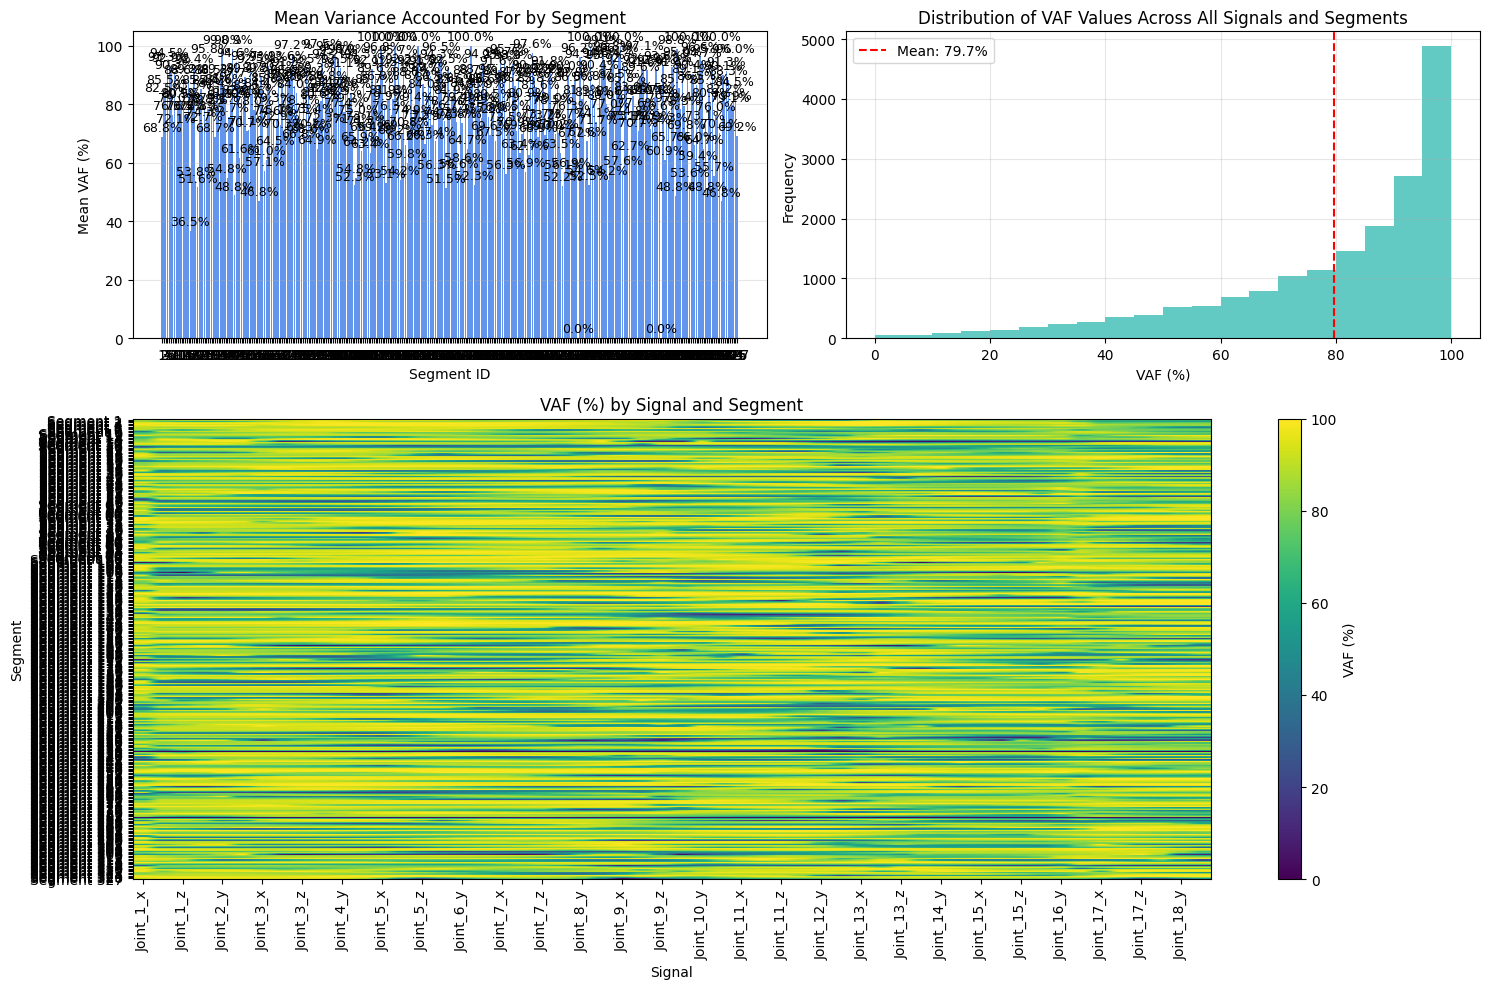

KeyError: 'fitted_values'

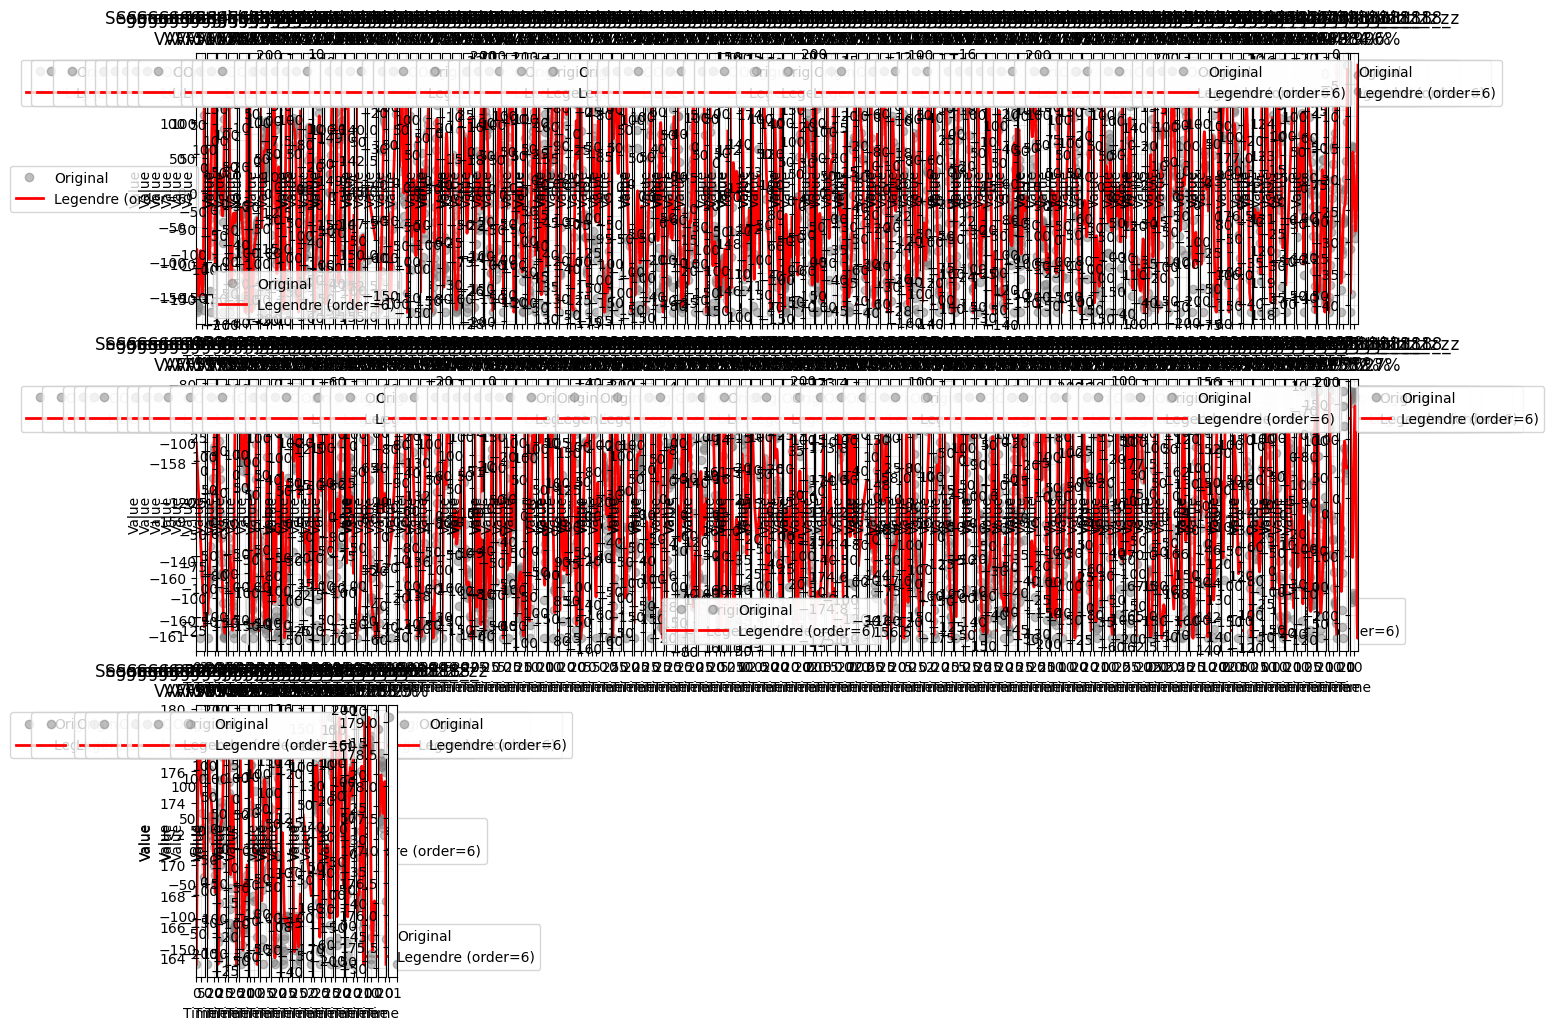

In [10]:


# Main execution
if __name__ == "__main__":
    # Use the path provided in your snippet
    destination_folder = "../../../data/MMpose/segmented_files/walking/bvh_files"
    folder_path = destination_folder
    
    # Read BVH files (replace with your actual implementation)
    bvh_data = read_bvh_files(folder_path)
    
    # Process the data (replace with your actual implementation)
    processed_data = process_bvh_data(bvh_data)
    
    # Create signal names (replace with your actual signal names)
    # This assumes 54 signals as mentioned in your snippet
    signal_names = []
    for i in range(18):  # Assuming these are joints
        for suffix in ['_x', '_y', '_z']:  # Each joint has x, y, z coordinates
            signal_names.append(f"Joint_{i+1}{suffix}")
    
    # Set the Legendre polynomial order
    poly_order = 6
    
    # Analyze the data
    results = analyze_mocap_segments(
        processed_data, 
        poly_order=poly_order,
        signal_names=signal_names,
        plot_summary=True,
        plot_details=True,
        max_signals_to_plot=6
    )
    
    # Print overall mean VAF
    print(f"Overall mean VAF across all segments and signals: {results['overall_mean_vaf']:.2f}%")
    
    # Identify signals with highest and lowest VAF
    vaf_by_signal = results['overall_vaf_by_signal']
    best_signal_idx = np.argmax(vaf_by_signal)
    worst_signal_idx = np.argmin(vaf_by_signal)
    
    print(f"\nSignal with highest VAF: {signal_names[best_signal_idx]} ({vaf_by_signal[best_signal_idx]:.2f}%)")
    print(f"Signal with lowest VAF: {signal_names[worst_signal_idx]} ({vaf_by_signal[worst_signal_idx]:.2f}%)")
    
    # Identify segments with highest and lowest mean VAF
    vaf_by_segment = results['overall_vaf_by_segment']
    best_segment_idx = np.argmax(vaf_by_segment)
    worst_segment_idx = np.argmin(vaf_by_segment)
    
    print(f"\nSegment with highest mean VAF: Segment {best_segment_idx+1} ({vaf_by_segment[best_segment_idx]:.2f}%)")
    print(f"Segment with lowest mean VAF: Segment {worst_segment_idx+1} ({vaf_by_segment[worst_segment_idx]:.2f}%)")